In [213]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
%matplotlib inline
import math

from pandas_datareader import data
import datetime
import quandl

In [214]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


In [215]:

from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

startDateStr = '2018/01/01'
endDateStr = '2019/12/12'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['WBC.ax','CBA.ax','NAB.ax','Boq.ax',
                 'ben.ax','anz.ax','aba.ax','mvb.ax']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']

Processing data for stock: WBC.ax
Processing data for stock: CBA.ax
Processing data for stock: NAB.ax
Processing data for stock: Boq.ax
Processing data for stock: ben.ax
Processing data for stock: anz.ax
Processing data for stock: aba.ax
Processing data for stock: mvb.ax
20% done...
40% done...
60% done...
80% done...


In [216]:
data.head(4)

,WBC.ax,CBA.ax,NAB.ax,Boq.ax,ben.ax,anz.ax,aba.ax,mvb.ax
2018-01-02,28.229094,71.531067,26.554262,11.349227,10.238972,26.165001,4.607576,26.307041
2018-01-03,28.211025,71.459732,26.473442,11.286573,10.212627,26.174156,4.642951,26.307041
2018-01-04,28.093594,71.308151,26.599167,11.259722,10.265315,26.110073,4.642951,26.307041
2018-01-05,28.427826,72.369255,26.805708,11.429782,10.440941,26.320637,4.660638,26.586494


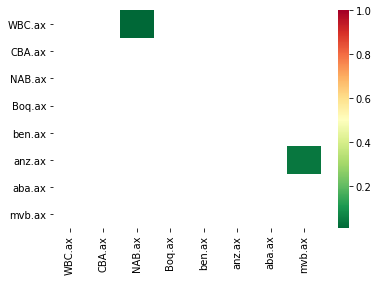

[('WBC.ax', 'NAB.ax'), ('anz.ax', 'mvb.ax')]


In [217]:

# Heatmap to show the p-values of the cointegration test
# between each pair of stocks

scores, pvalues, pairs = find_cointegrated_pairs(data)
import seaborn
#m = [0,0.2,0.4,0.6,0.8,1]
m = np.linspace(0,1,6)
seaborn.heatmap(pvalues, xticklabels=instrumentIds, 
                yticklabels=instrumentIds, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
plt.show()
print(pairs)

P-Value                        :  0.01639
T-stat score for co-integration:  -3.7375


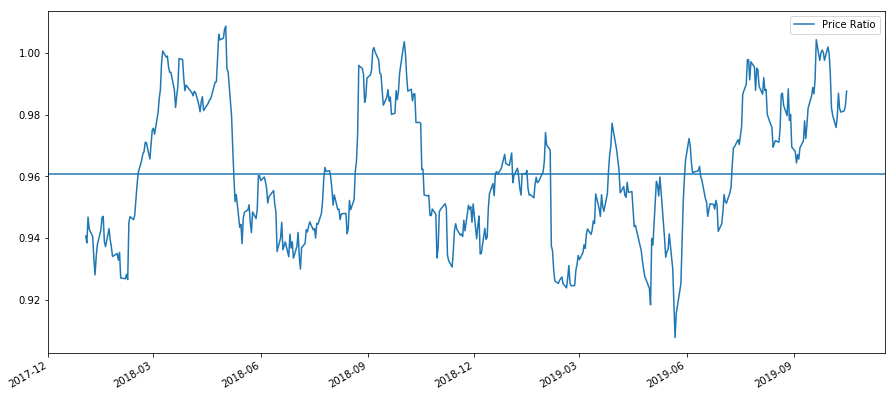

In [218]:
S1 = data['NAB.ax']
S2 = data['WBC.ax']
ticker_1 = "NAB"
ticker_2 = "WBC"
score, pvalue, _ = coint(S1, S2)
print('P-Value                        : ',pvalue.round(5))
print("T-stat score for co-integration: ",score.round(5))
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

In [219]:
t_stat_summary = statsmodels.tsa.stattools.coint(S1, S2, trend='c', method='aeg', maxlag=None, autolag='aic', return_results=True) 

In [220]:
print('----------Co-Integration Test-------------------')
print('T-stat for the pair {} VS {}:'.format(ticker_1,ticker_2), t_stat_summary[0])
print('Alpha value for the T-stat:  {}'.format(t_stat_summary[1]))
print('--------------------------------------')
print('T-stat 99%:  {}'.format(t_stat_summary[2][0]))
print('T-stat 95%:  {}'.format(t_stat_summary[2][1]))
print('T-stat 90%:  {}'.format(t_stat_summary[2][2]))

----------Co-Integration Test-------------------
T-stat for the pair NAB VS WBC: -3.737495933230913
Alpha value for the T-stat:  0.01638771450962326
--------------------------------------
T-stat 99%:  -3.920779759464741
T-stat 95%:  -3.3496513284992373
T-stat 90%:  -3.0538257271854548


In [221]:
# ADF check
from statsmodels.tsa.stattools import adfuller
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
adf_check(ratios)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.4796927372927495
p-value : 0.008524203329866182
#Lags Used : 3
Number of Observations Used : 450
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [222]:
corr_M = np.corrcoef(S1,S2)
print("Correlation Matrix:  ")
print("---------------------")
print(corr_M)

Correlation Matrix:  
---------------------
[[1.         0.93035674]
 [0.93035674 1.        ]]


In [223]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

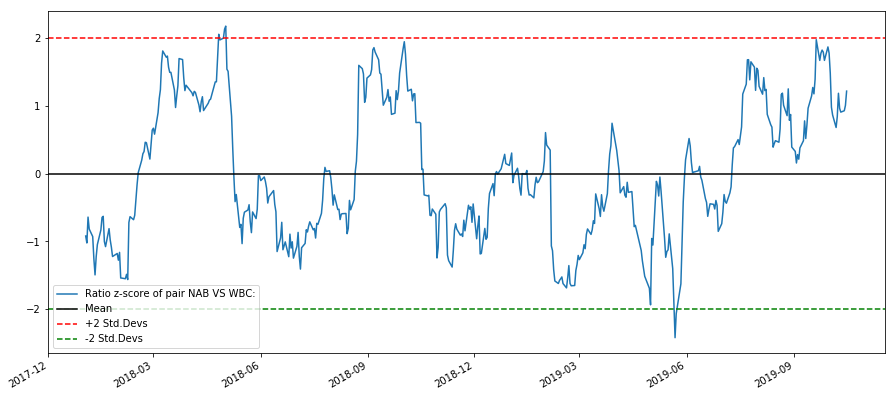

In [224]:
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')
plt.legend(['Ratio z-score of pair {} VS {}:'.format(ticker_1,ticker_2), 'Mean', '+2 Std.Devs', '-2 Std.Devs'])
plt.show()

In [225]:
ratios = S1 / S2
print(len(ratios))
train = ratios[:504]
test = ratios[504:]

454


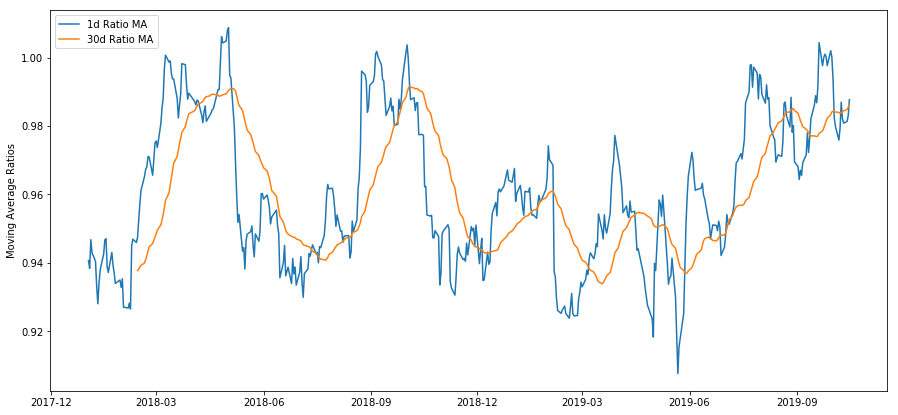

In [226]:
ratios_mavg1 = train.rolling(window=1,
                               center=False).mean()

ratios_mavg_long = train.rolling(window=30,
                               center=False).mean()

std_long = train.rolling(window=30,
                        center=False).std()

zscore_long_1 = (ratios_mavg1 - ratios_mavg_long)/std_long
plt.figure(figsize=(15,7))
plt.plot(ratios_mavg1.index, ratios_mavg1.values)
plt.plot(ratios_mavg_long.index, ratios_mavg_long.values)

plt.legend(['1d Ratio MA', '30d Ratio MA'])

plt.ylabel('Moving Average Ratios')
plt.show()

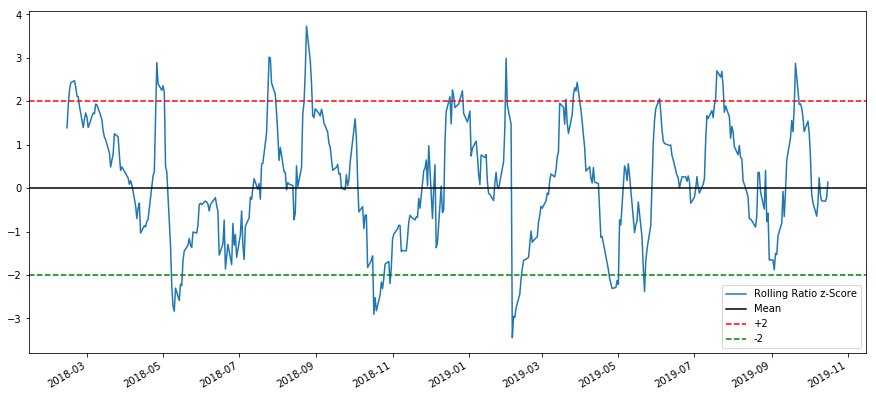

In [227]:
# Take a rolling 30 day standard deviation
std_long = train.rolling(window=30,center=False).std()
std_long.name = 'std 30d'

# Compute the z score for each day
zscore_long_1 = (ratios_mavg1 - ratios_mavg_long)/std_long
zscore_long_1.name = 'z-score'

plt.figure(figsize=(15,7))
zscore_long_1.plot()
plt.axhline(0, color='black')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+2', '-2'])
plt.show()


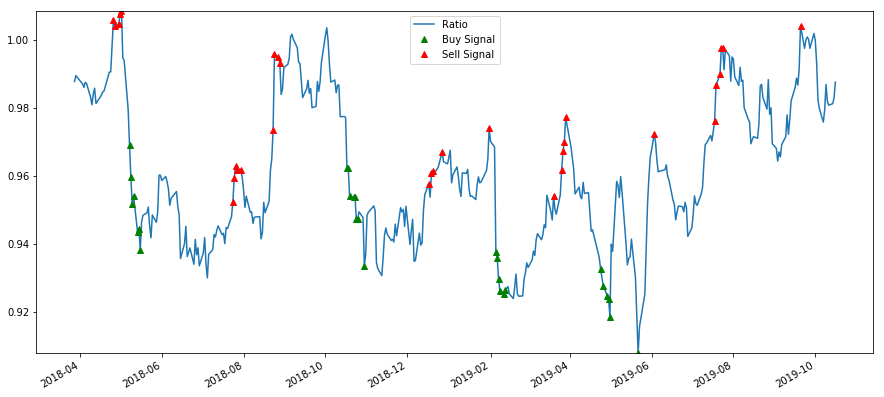

In [228]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))

train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_long_1>-2] = 0
sell[zscore_long_1<2] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

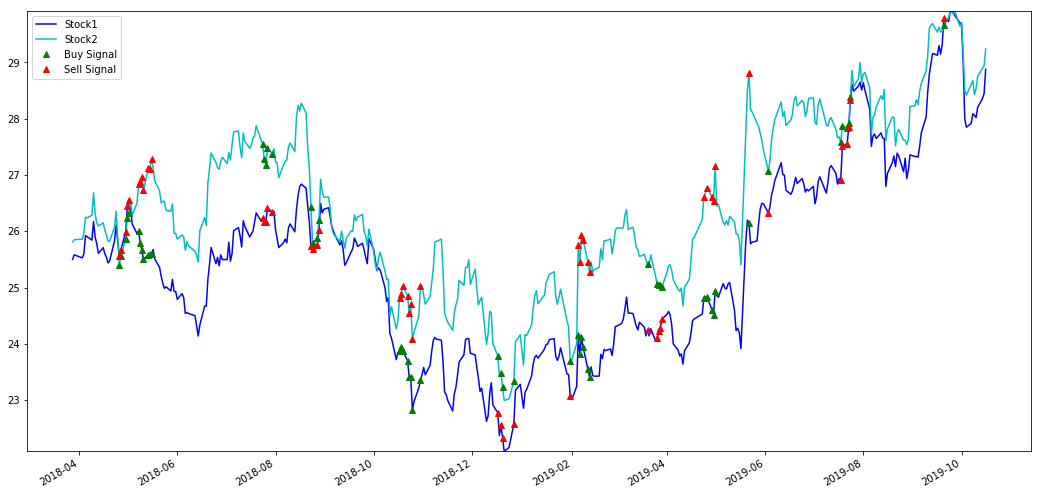

In [229]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))


S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend(['Stock1','Stock2', 'Buy Signal', 'Sell Signal'])
plt.show()

In [233]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    money_counter = []
    for i in range(len(ratios)):
        # Sell short if the z-score is > 2
        if zscore[i] > 2.0:
            money += S1[i] - S2[i] * ratios[i]
            money_counter.append(money)
            countS1 -= 1
            countS2 += ratios[i]
            print('Selling Ratio %s %s %s %s'%(round(money,2), round(ratios[i],2), round(countS1,2),round(countS2,2)))
            
        # Buy long if the z-score is < -2
        elif zscore[i] < -2.0:
            money -= S1[i] - S2[i] * ratios[i]
            money_counter.append(money)
            countS1 += 1
            countS2 -= ratios[i]
            print('Buying Ratio %s %s %s %s'%(round(money,2), round(ratios[i],2), round(countS1,2),round(countS2,2)))
        # Clear positions if the z-score between -.1 and .1
        elif abs(zscore[i]) < 0.1:
            money += countS1*S1[i] - S2[i] * countS2
            money_counter.append(money)
            countS1 = 0
            countS2 = 0
            print('Exit pos %s %s %s %s'%(round(money,2), round(ratios[i],2), round(countS1,2),round(countS2,2)))
    print(money_counter)
    df = pd.DataFrame(money_counter).diff()
    
    dollar_returns = df
    
    print(dollar_returns)
    
    return money
    
    
    
td = (trade(S1.iloc[:504], S2.iloc[:504], 1, 60))*1000
print("backtested ratio: ", ratios[-1:])
print("Profit from the pair:  ", round(td,2))
#td_100 = td * 100
#print("Profit from 100 units at above ratio:  ", td_100)

Buying Ratio 0.0 0.95 1 -0.95
Buying Ratio 0.0 0.95 2 -1.91
Buying Ratio 0.0 0.94 3 -2.85
Buying Ratio 0.0 0.94 4 -3.79
Buying Ratio 0.0 0.94 5 -4.73
Buying Ratio 0.0 0.95 6 -5.68
Buying Ratio 0.0 0.95 7 -6.63
Buying Ratio 0.0 0.94 8 -7.57
Exit pos 416.57 0.95 0 0
Selling Ratio 416.57 0.97 -1 0.97
Selling Ratio 416.57 1.0 -2 1.97
Selling Ratio 416.57 0.99 -3 2.96
Selling Ratio 416.57 0.99 -4 3.96
Selling Ratio 416.57 0.98 -5 4.94
Selling Ratio 416.57 0.99 -6 5.93
Selling Ratio 416.57 0.99 -7 6.92
Selling Ratio 416.57 0.99 -8 7.91
Selling Ratio 416.57 0.99 -9 8.91
Selling Ratio 416.57 1.0 -10 9.91
Selling Ratio 416.57 1.0 -11 10.91
Selling Ratio 416.57 1.0 -12 11.91
Exit pos -166.41 0.98 0 0
Exit pos -166.41 0.98 0 0
Exit pos -166.41 0.98 0 0
Buying Ratio -166.41 0.93 1 -0.93
Buying Ratio -166.41 0.93 2 -1.87
Buying Ratio -166.41 0.93 3 -2.8
Buying Ratio -166.41 0.93 4 -3.73
Exit pos 13.48 0.96 0 0
Selling Ratio 13.48 0.97 -1 0.97
Buying Ratio 13.48 0.93 0 0.04
Buying Ratio 13.48 0.93 1

In [231]:
##CAGR, SHARPE ratio, tota ROI, to be done

In [232]:
Sharpe_ratio = td.mean()/td.std() * np.sqrt(252)

C:\Users\samar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in double_scalars

